In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pgf import FigureCanvasPgf

mpl.backend_bases.register_backend("pdf", FigureCanvasPgf)
mpl.use("pgf")
%matplotlib inline
%config InlineBackend.figure_format="retina"

# Pandas options
pd.set_option('display.max_colwidth', -1) # max column width (-1 wraps text)
pd.set_option('display.max_rows', 25)     # max num of rows to display

# Matplotlib options
plt.style.use("seaborn-paper")
plt.rcParams.update({
    "axes.labelsize": 18,               # label size (x- and y-axis)
    "axes.titlesize": 22,               # title size on (most) axes
    "figure.titlesize": 22,             # title size for fig.sup_title()
    "legend.fontsize": "large",         # font size for legend
    "lines.markersize": 6,              # marker size for points and lines
    "lines.markeredgewidth": 2,         # marker edgewidth for points
    "xtick.labelsize": 14,              # label size for x-axis ticks 
    "ytick.labelsize": 14,              # label size for y-axis ticks

    "font.family": "serif",             # use serif/main font for text elements
    "text.usetex": True,                # use inline math for ticks
    "pgf.rcfonts": False,               # don't setup fonts from rc params
    "pgf.preamble": [
        # Syling
        r"\usepackage{color}",          # special colors
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble

        # Math
        r"\usepackage{xfrac}",          # side fractions
        r"\usepackage{amsthm}",         # theorems
        r"\usepackage{amsmath}",        # misc math
        r"\usepackage{amssymb}",        # blackboard math symbols
        r"\usepackage{mathtools}",      # enhance the appearance of math
    ],
})


from profit.dataset import generator
from profit.dataset.preprocessing import mol_feats
from profit.dataset.preprocessing.mutator import PDBMutator

Using TensorFlow backend.


# 3D structural features

## Mutate protein

In [2]:
mutator = PDBMutator(fmt="tertiary", rootdir="../../data/tmp", cache=False)
mol = mutator.mutate("3gb1", replace_with={39: "T", 40: "N", 41: "T", 54: "Y"})

Selected!
 Mutagenesis: 1 rotamers loaded.
 Mutagenesis: 2 rotamers loaded.
 Rotamer 1/2, strain=21.70
Selected!
 Mutagenesis: 3 rotamers loaded.
 Mutagenesis: 10 rotamers loaded.
 Rotamer 7/10, strain=19.60
Selected!
 Mutagenesis: 10 rotamers loaded.
 Mutagenesis: 1 rotamers loaded.
 Rotamer 1/1, strain=53.26
Selected!
 Mutagenesis: 3 rotamers loaded.
 Mutagenesis: 4 rotamers loaded.
 Rotamer 2/4, strain=56.67
 Rotamer 2/4, strain=56.67


In [3]:
atom_feats = mol_feats.construct_mol_features(mol)
adj_matrix = mol_feats.construct_adj_matrix(mol, normalize=True)
pos_matrix = mol_feats.construct_pos_matrix(mol)

## Molecular features

Text(0.5, 28.502095170454545, 'Feature')

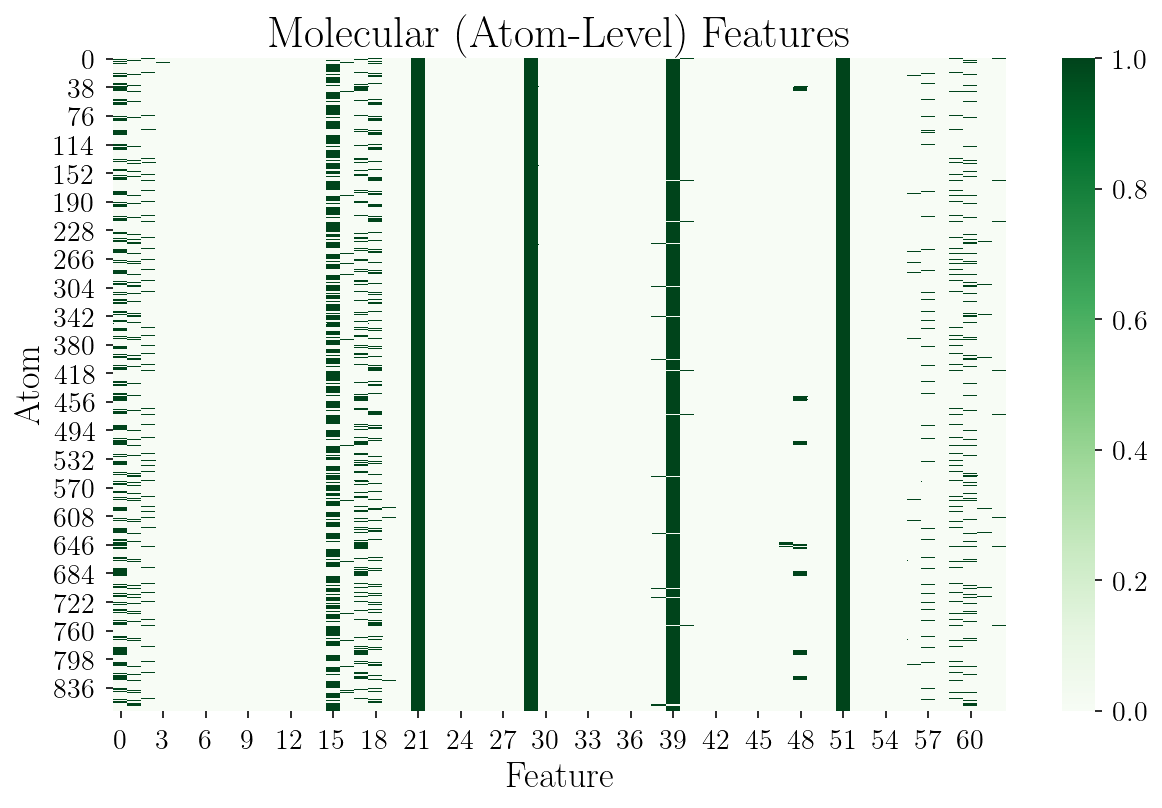

In [4]:
plt.figure(figsize=(10,6))
sns.heatmap(atom_feats, cmap="Greens")
plt.title('Molecular (Atom-Level) Features')
plt.ylabel('Atom')
plt.xlabel('Feature')

## Adjacency matrix

Text(0.5, 113.10209517045452, 'Atom')

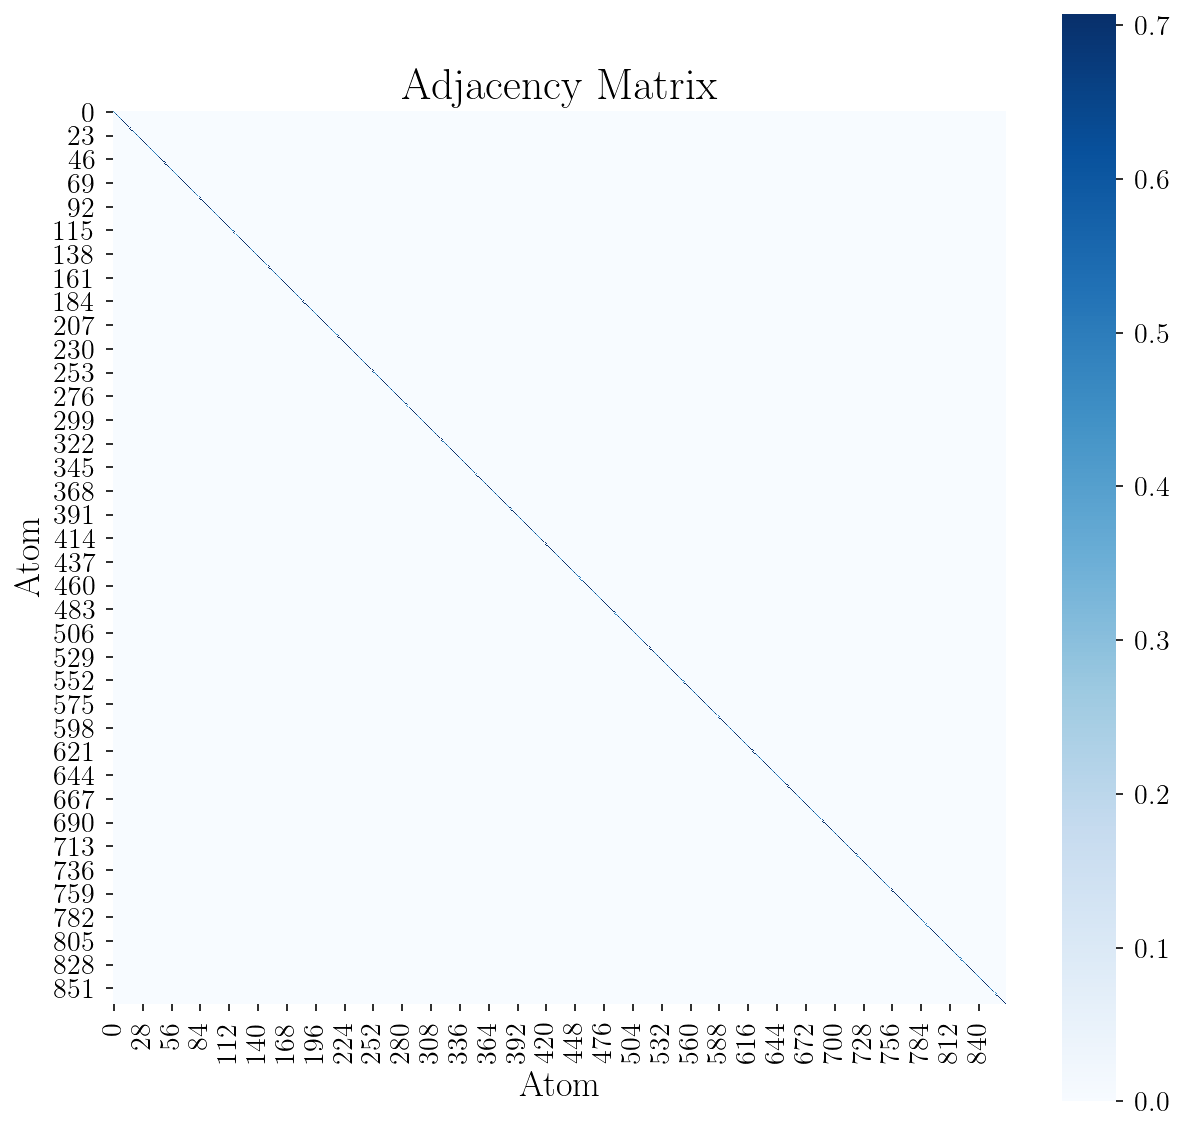

In [5]:
plt.figure(figsize=(10,10))
sns.heatmap(adj_matrix, cmap='Blues', square=True)
plt.title('Adjacency Matrix')
plt.ylabel('Atom')
plt.xlabel('Atom')

## Euclidean distance

In [6]:
xyz_pos = np.reshape(pos_matrix, newshape=(-1, 3))
origin = np.zeros_like(xyz_pos)
euclidean_dists = np.linalg.norm(origin-xyz_pos, axis=1) # row-wise euclidean distances
n_atoms = int(np.sqrt(euclidean_dists.shape[0]))
euclidean_pos_matrix = np.reshape(euclidean_dists, newshape=(n_atoms, n_atoms))

Text(0.5, 113.10209517045452, 'Atom')

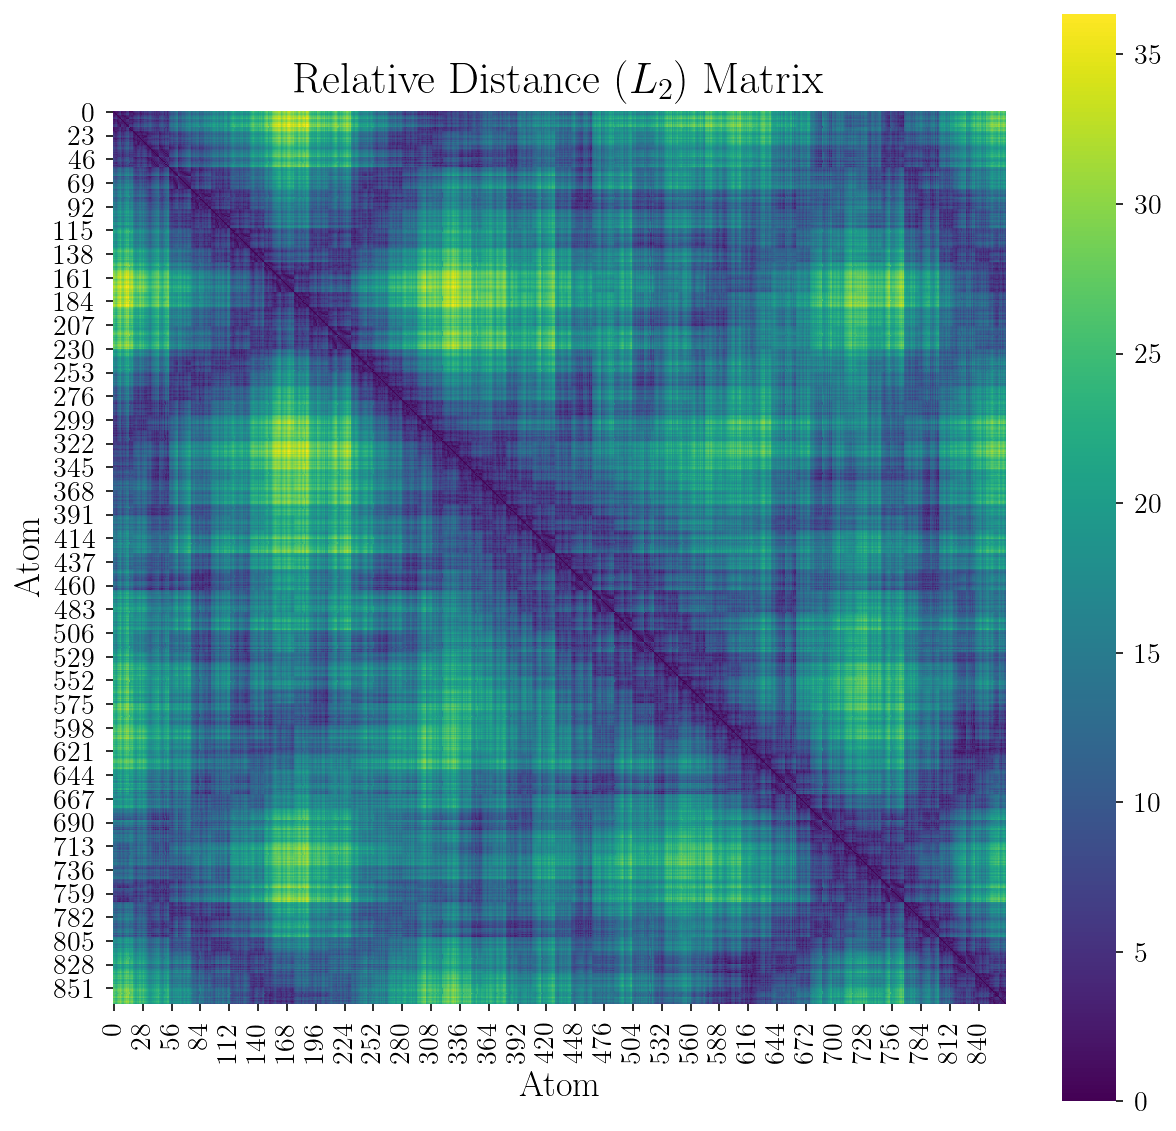

In [7]:
plt.figure(figsize=(10,10))
sns.heatmap(euclidean_pos_matrix, cmap="viridis", square=True)
plt.title('Relative Distance ($L_2$) Matrix')
plt.ylabel('Atom')
plt.xlabel('Atom')

# Fitness

## Distribution

In [8]:
df = pd.read_csv("../../data/3gb1/raw/fitness570.csv", sep=',')
df.tail(n=10)

,ID,Variants,Fitness
560,19558,VAAM,1.600054
561,9021,HYGT,1.681497
562,19973,VCFT,1.705494
563,18065,SHGW,1.807289
564,29222,AIAA,2.140591
565,453,HYGV,2.487164
566,9570,IHGC,3.108682
567,116008,QWCA,3.670790
568,142253,WWMG,4.916300
569,76933,IYCA,5.073268


(array([534.,  14.,   6.,   3.,   3.,   0.,   3.,   1.,   1.,   1.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   2.]),
 array([0.        , 0.25366338, 0.50732677, 0.76099015, 1.01465353,
        1.26831691, 1.5219803 , 1.77564368, 2.02930706, 2.28297045,
        2.53663383, 2.79029721, 3.04396059, 3.29762398, 3.55128736,
        3.80495074, 4.05861413, 4.31227751, 4.56594089, 4.81960428,
        5.07326766]),
 <a list of 20 Patch objects>)

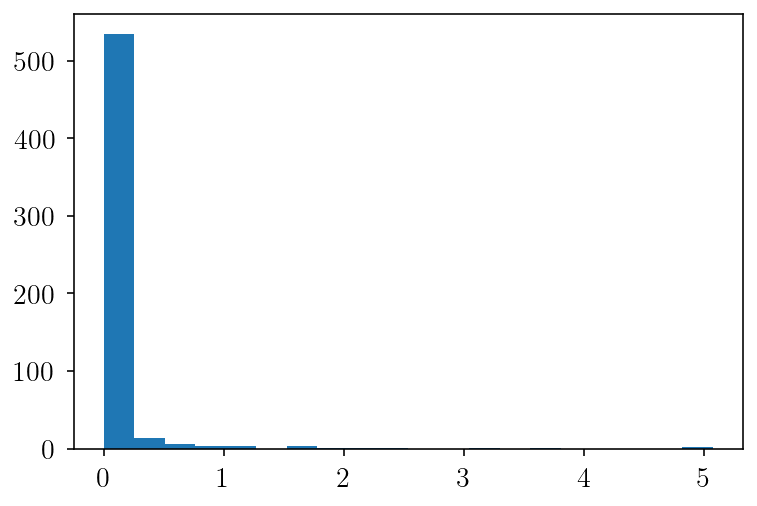

In [9]:
plt.hist(df["Fitness"], bins=20)

## Landscape map
We want to plot the fitness of the protein for discrete variants of 4 amino acids, which come from a subset of the sequence -> fitness dataset. Convert the sequence to a 2x2 representation so that we can plot it. i.e TNTY -> TN, TY on the x and y axis, respectively. This way we can view both (a) the sparsity of the fitness data we are given and (b) the fitness landscape as it s initially.   

In [10]:
combs = generator.gen(n=2)
fitness_df = pd.DataFrame(0.0, index=combs, columns=combs)
fitness_df.head()

,AA,AR,AN,AD,AC,AQ,AE,AG,AH,AI,...,VL,VK,VM,VF,VP,VS,VT,VW,VY,VV
AA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
for idx, row in df.iterrows():
    variant = row['Variants']
    x,y = variant[:2], variant[2:]
    fitness_df.at[x,y] = row['Fitness']

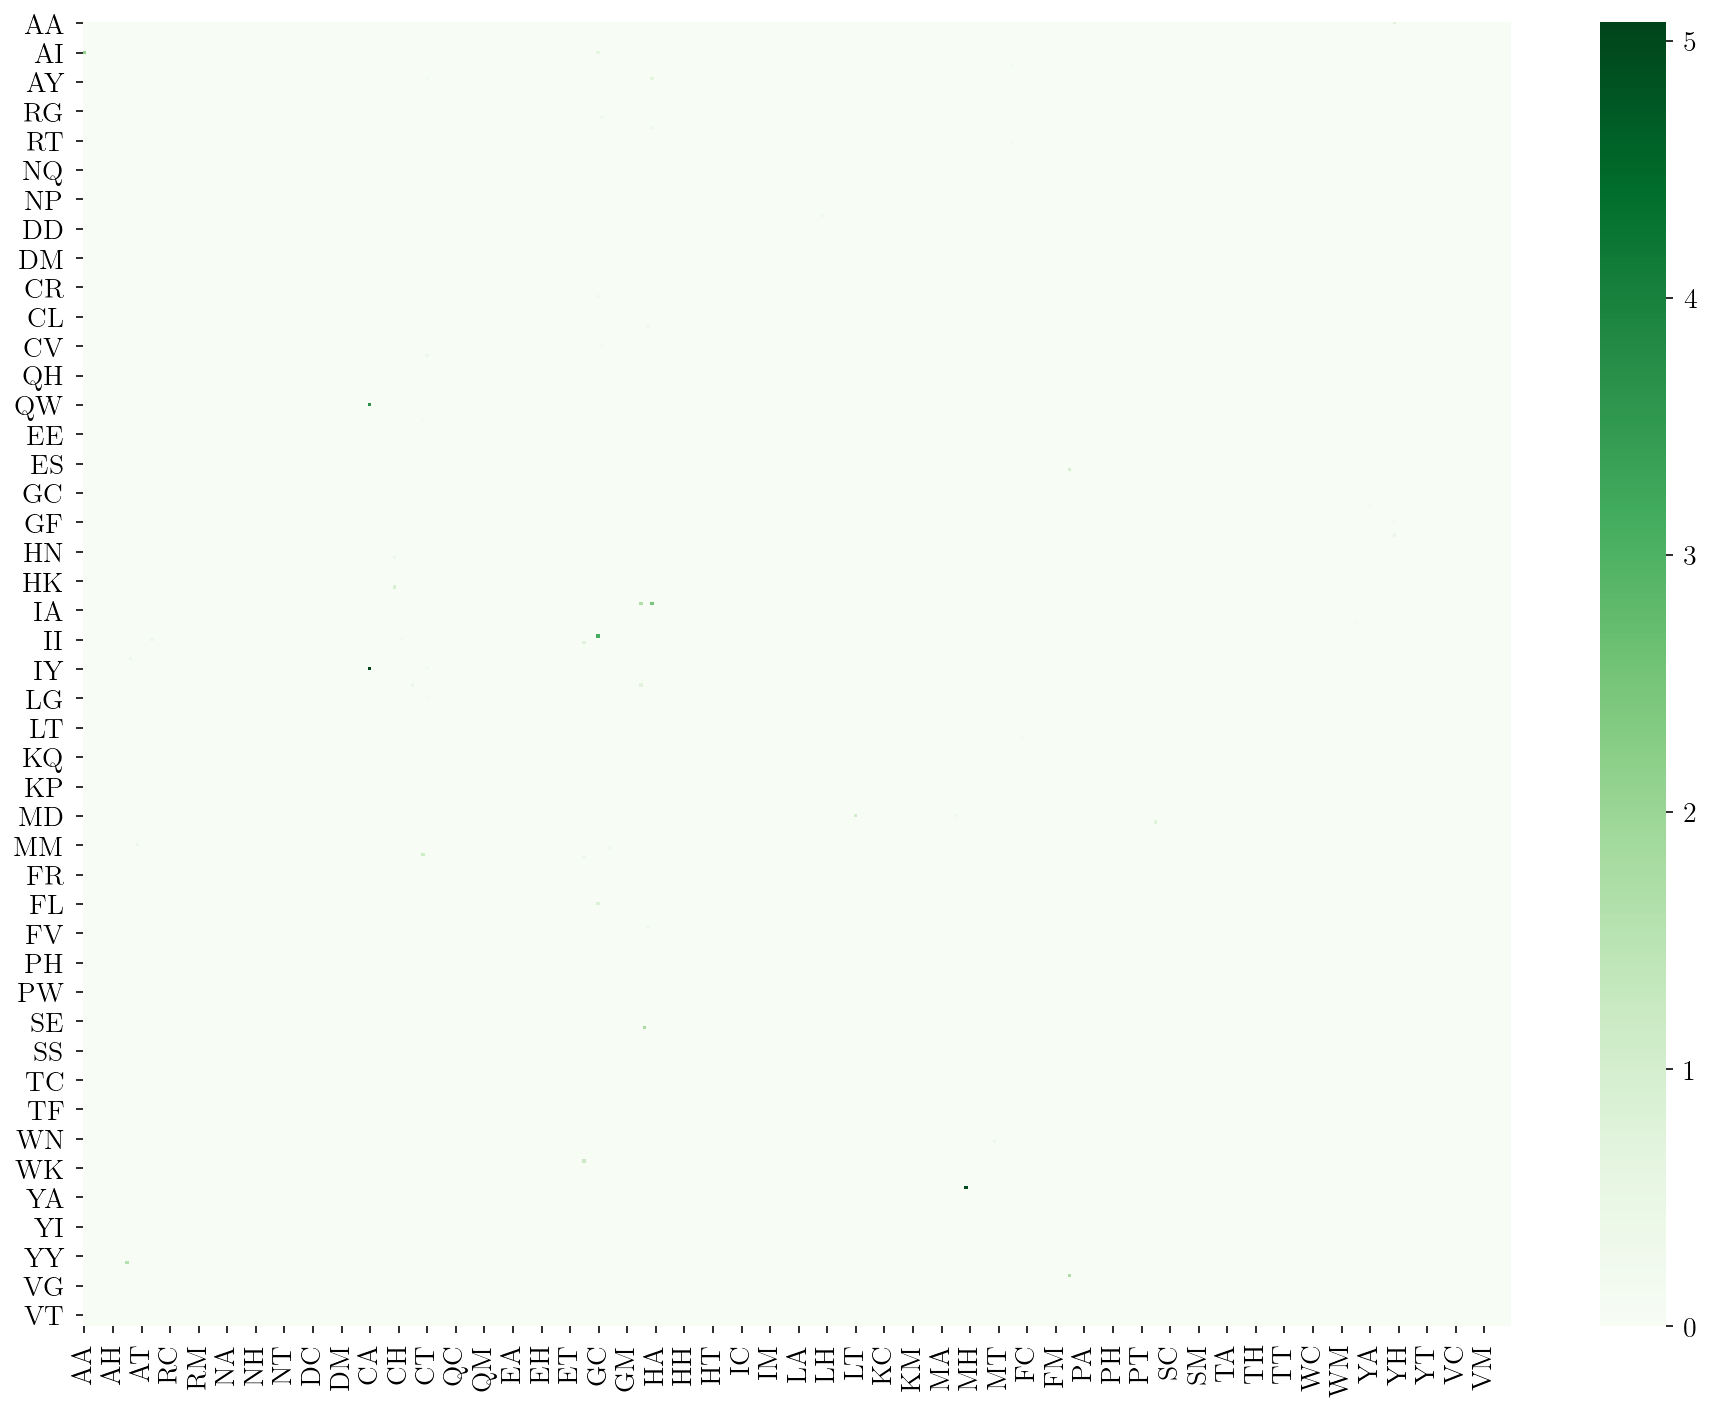

In [12]:
plt.figure(figsize=(16,12))
sns.heatmap(fitness_df, cmap='Greens')

## Hamming distance
Is a correlation between hamming distance (string difference between the parental evolved sequence) and its fitness score?

In [13]:
def hamming_dist(s1, s2):
    """
    Determine the number of positions/chars it takes 
    to get from the first string to the second. 
    
    Params:
    -------
    s1: str
    s2: str
        The strings to compare.
    
    Returns:
    --------
    dist: int
        The distance between the strings. 
    """
    assert len(s1) == len(s2)
    return len([True for ch1,ch2 in zip(s1,s2) if ch1 != ch2])

def compute_distance(row):
    return hamming_dist(row['Variants'], 'VDGV')

In [14]:
df['Hamming'] = df.apply(compute_distance, axis=1)
df.head(n=10)

,ID,Variants,Fitness,Hamming
0,133462,TNTY,0.0,4
1,30784,APPP,0.0,4
2,130974,TFFM,0.0,4
3,9290,IDMW,0.0,3
4,43174,DRNQ,0.0,4
5,101152,NPYI,0.0,4
6,45144,EAQQ,0.0,4
7,104378,PEKW,0.0,4
8,4899,ECIV,0.0,3
9,19282,TPIV,0.0,3


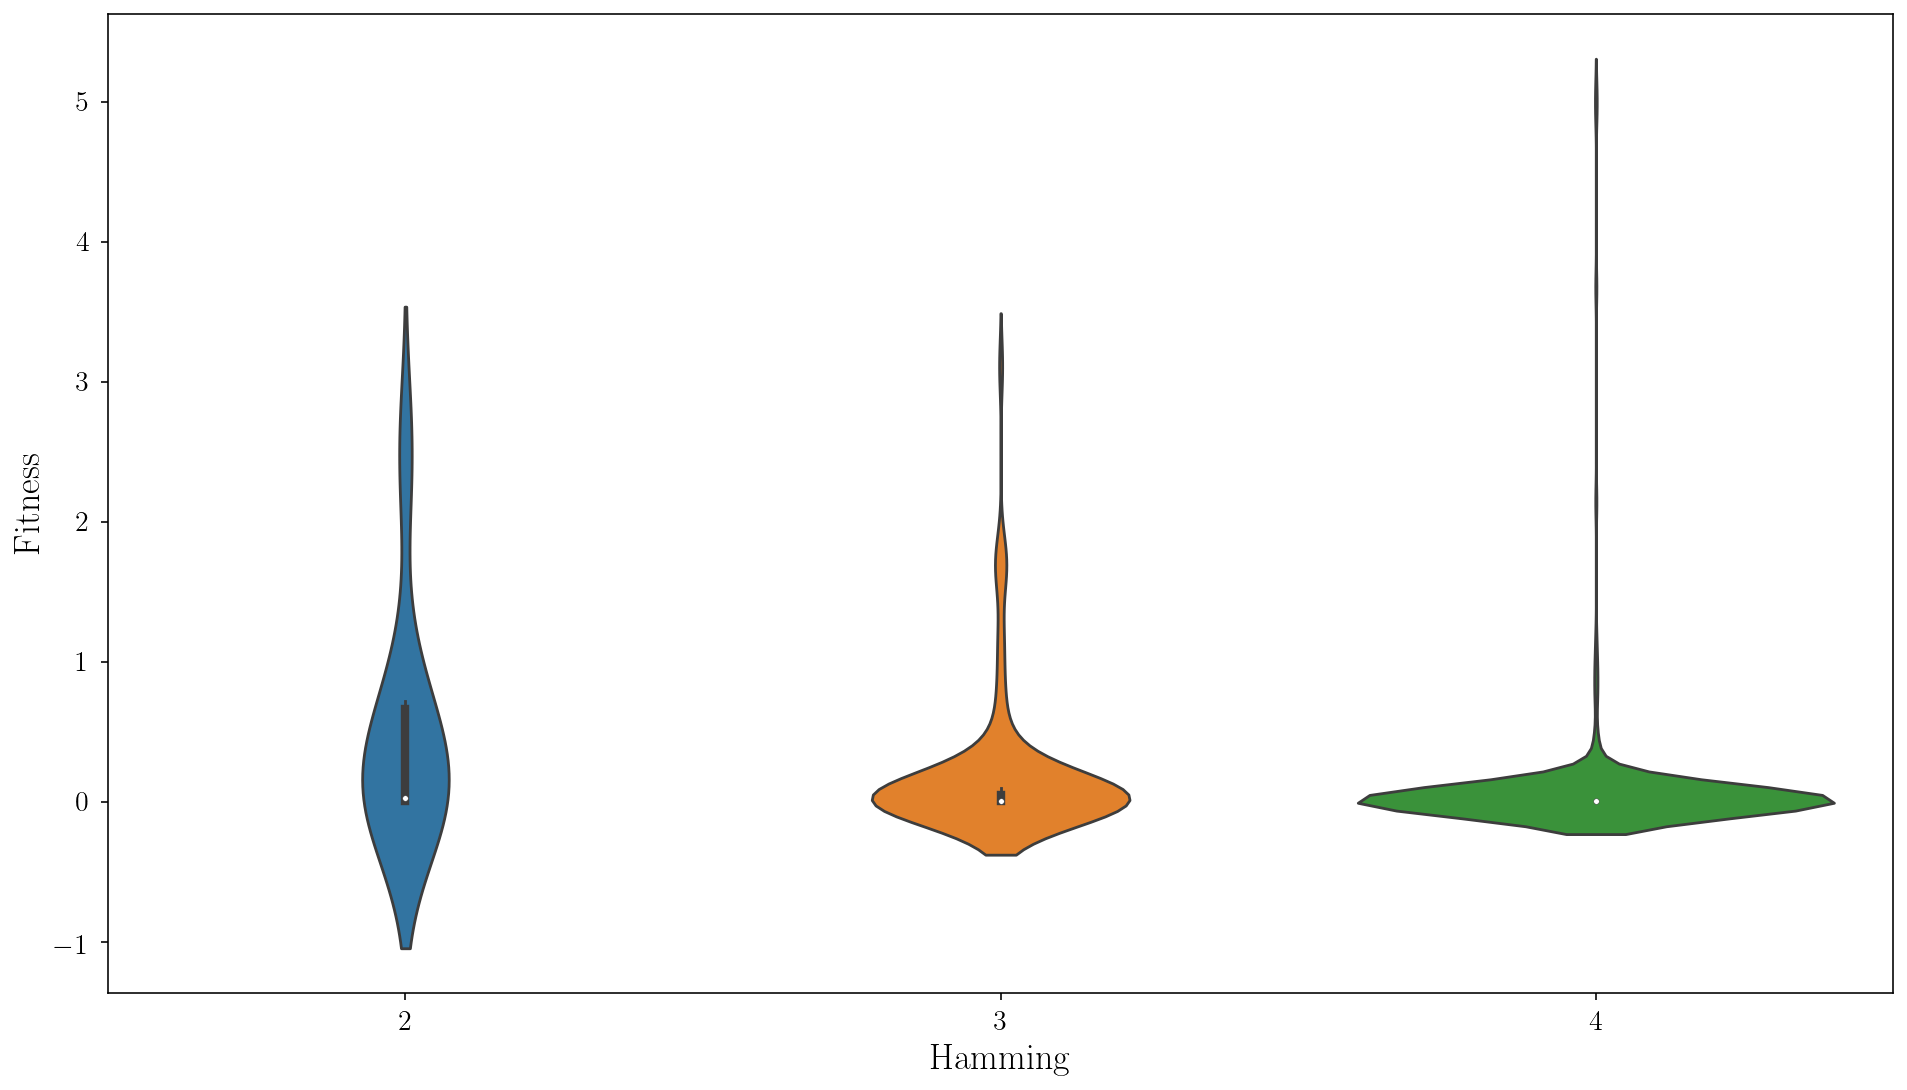

In [15]:
plt.figure(figsize=(16,9))
sns.violinplot(x="Hamming", y="Fitness", data=df)